In [1]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare


rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 1.91 µs


In [2]:
#def reset_esn()の定義
#reset_esn()は一体何に使うのか？

def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                          lr=leak_rate, rc_connectivity=connectivity,
                          input_connectivity=input_connectivity, seed=seed)
    readout   = Ridge(1, ridge=regularization)

    return reservoir >> readout

2\piが1日に対応する周期をVDP+sin(x)のモデルについて，次のように変化を加える．

四日に一回位相を八時間分だけ進める．
よって，位相を\thetaとすると，\thetaのグラフは階段状のグラフとなるはずである．

また，シミュレーションを行う際，Aの値を調整して，次の要項を満たすとする．
グラフの周期的な形状が，たまに消失する部分（波打っていたところが横線など他の形状に変わる）がある．

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt

def phase_shift(t):
    # 2πは1日に対応します。8時間は(8/24)*2πに対応します。
    shift_value = (8/24)*2*np.pi
    # 4日ごとに位相をシフトします。
    number_of_shifts = int(t / (4*2*np.pi))
    return number_of_shifts * shift_value

def modified_forced_van_der_pol(t, z, mu, A, omega):
    x, y = z  # 値をアンパックします。
    dxdt = y
    # omega*tの項にphase_shiftを追加します。
    dydt = mu * (1 - x**2) * y - x + A * np.sin(omega * t + phase_shift(t))
    return [dxdt, dydt]

mu = 1.0
omega = 1.0
initial_state = [1.0, 0.0]
t_span = (0, 2510)

# グラフの周期的な形状が時折消失するようにAの値を調整します。
A_adjusted = 1.2

# 変更されたVDPモデルでシミュレーションを行います。
sol_modified = solve_ivp(modified_forced_van_der_pol, t_span, initial_state, args=(mu, A_adjusted, omega), dense_output=True, t_eval=np.linspace(t_span[0], t_span[1], 25100), max_step = 0.01)

t_modified = sol_modified.t
x_modified = sol_modified.y[0]
y_modified = sol_modified.y[1]
# sin(omega * t + phase_shift(t)) の計算
s_modified = np.sin(omega * t_modified + np.array([phase_shift(ti) for ti in t_modified]))

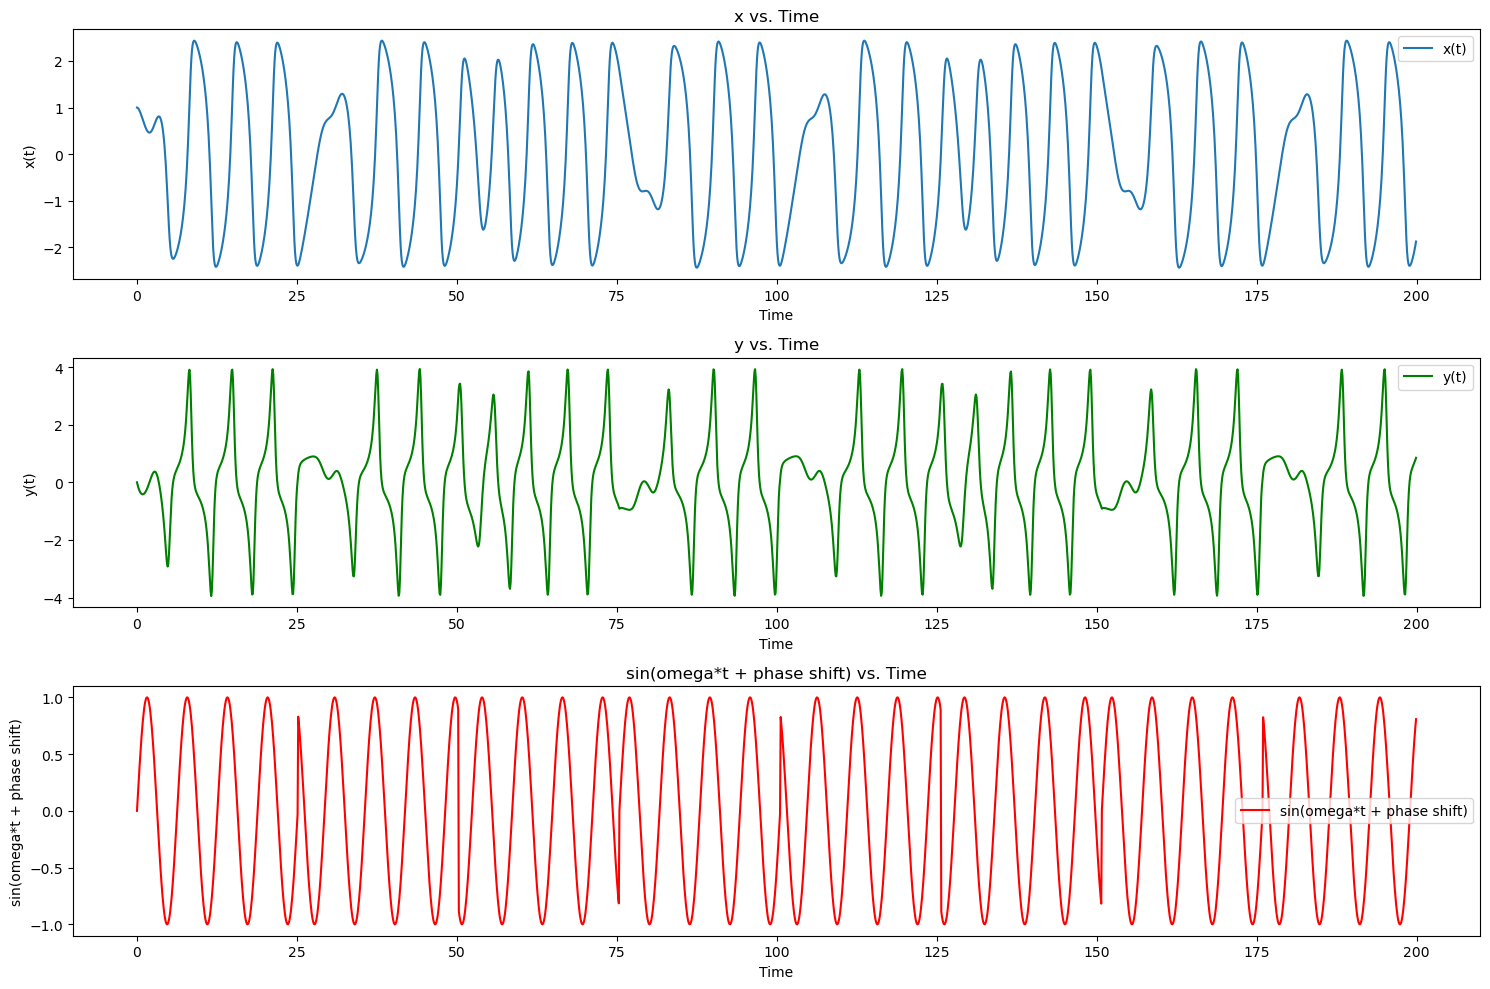

In [4]:
def plot_data(t, x, y, s, plot_span):
    plt.figure(figsize=(15, 10))
    
    # x vs. 時間 のグラフを描画
    plt.subplot(3, 1, 1)
    plt.plot(t[:plot_span], x[:plot_span], label='x(t)')
    plt.title('x vs. Time')
    plt.xlabel('Time')
    plt.ylabel('x(t)')
    plt.legend()
    
    # y vs. 時間 のグラフを描画
    plt.subplot(3, 1, 2)
    plt.plot(t[:plot_span], y[:plot_span], label='y(t)', color='green')
    plt.title('y vs. Time')
    plt.xlabel('Time')
    plt.ylabel('y(t)')
    plt.legend()
    
    # sin(omega*t + phase_shift) vs. 時間 のグラフを描画
    plt.subplot(3, 1, 3)
    plt.plot(t[:plot_span], s[:plot_span], label='sin(omega*t + phase shift)', color='red')
    plt.title('sin(omega*t + phase shift) vs. Time')
    plt.xlabel('Time')
    plt.ylabel('sin(omega*t + phase shift)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 変更されたデータを描画
plot_data(t_modified, x_modified, y_modified, s_modified, 2000)

In [5]:
data_withouttime = pd.DataFrame({'x': x_modified, 'y': y_modified, 'sin': s_modified})

# CSVファイルを読み込む
data_loaded = pd.read_csv('modified_forced_vanderpol_dataset.csv')

X = data_withouttime.values

In [6]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, iss, N, sr, lr, ridge, seed):
    
    # This step may vary depending on what you put inside 'dataset'
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data
    
    # You can access anything you put in the config 
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances, 
    # to be sure there is no bias in the results 
    # due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(N, 
                              sr=sr, 
                              lr=lr, 
                              input_scaling=iss, 
                              seed=variable_seed)
        
        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(X_train, y_train) \
                           .run(X_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(X_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [7]:
hyperopt_config = {
    "exp": f"hyperopt-multiscroll", # the experimentation name
    "hp_max_evals": 200,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["uniform", 0, 1],           # the input scaling uniformly distributed between 0 and 1
        "ridge": ["loguniform", 1e-9, 1e-2],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [8]:
from reservoirpy.datasets import to_forecasting

train_len = 3000
test_len = 4000

x, y = to_forecasting(X, forecast=1)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:train_len+test_len], y[train_len:train_len+test_len]

dataset = ((X_train, y_train), (X_test, y_test))

In [9]:
from reservoirpy.hyper import research

best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

100%|██████████| 200/200 [06:23<00:00,  1.92s/trial, best loss: 0.005236255720831049]


In [10]:
best

({'N': 0,
  'iss': 0.6062643158179813,
  'lr': 0.48657161636196294,
  'ridge': 0.00019371347794085468,
  'seed': 0,
  'sr': 1.3671630828846324},
 <hyperopt.base.Trials at 0x28d0a3ac0>)

In [11]:
# bestから取得したハイパーパラメータを設定
N = 500
iss = 0.6062643158179813
lr = 0.48657161636196294
ridge = 0.00019371347794085468
seed = 1234
sr = 1.3671630828846324

In [12]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
    readout = Ridge(ridge=ridge)

    return reservoir >> readout

In [13]:
# モデルの構築
reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
readout = Ridge(ridge=ridge)
model = reservoir >> readout

# モデルの訓練と予測
predictions = model.fit(X_train, y_train).run(X_test)

# 評価（lossとr2の計算方法は既存のものを使用しています）
loss = nrmse(y_test, predictions, norm_value=np.ptp(X_train))
r2 = rsquare(y_test, predictions)

print("Loss:", loss)
print("R^2:", r2)

Loss: 0.00527716258399074
R^2: 0.9991177556849905


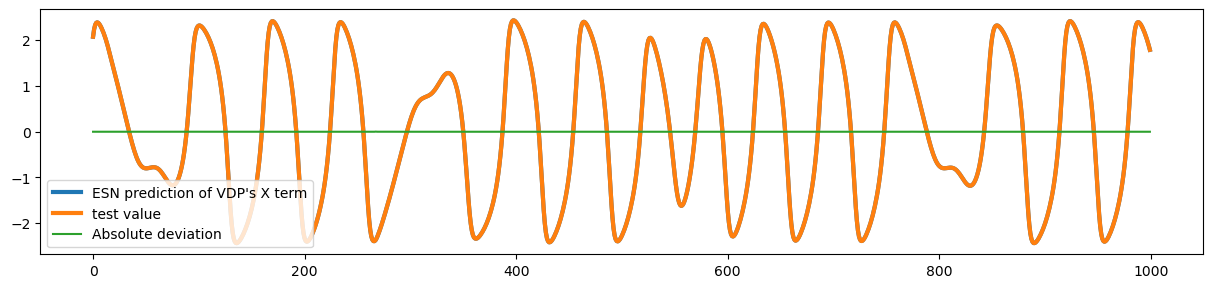

In [14]:
sample = 1000

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, :1][:sample], lw=3, label="ESN prediction of VDP's X term")
plt.plot(np.arange(sample), y_test[:, :1][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, :1][:sample] - predictions[:, :1][:sample]), label="Absolute deviation")

plt.legend()
plt.show()

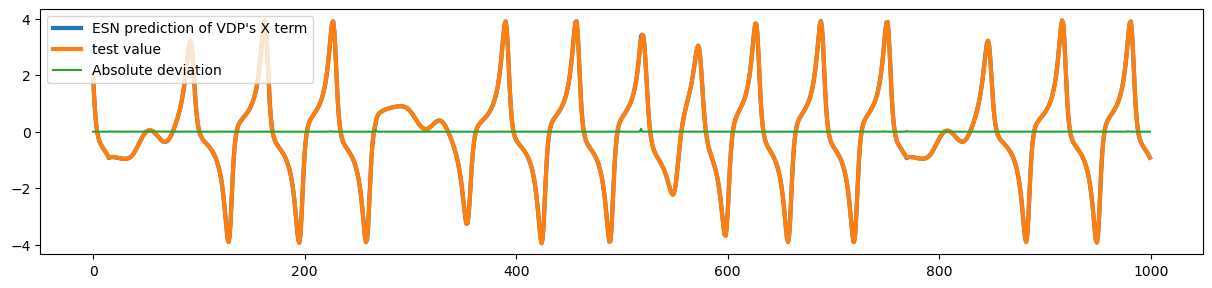

In [15]:
sample = 1000

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, 1:2][:sample], lw=3, label="ESN prediction of VDP's X term")
plt.plot(np.arange(sample), y_test[:, 1:2][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, 1:2][:sample] - predictions[:, 1:2][:sample]), label="Absolute deviation")

plt.legend()
plt.show()

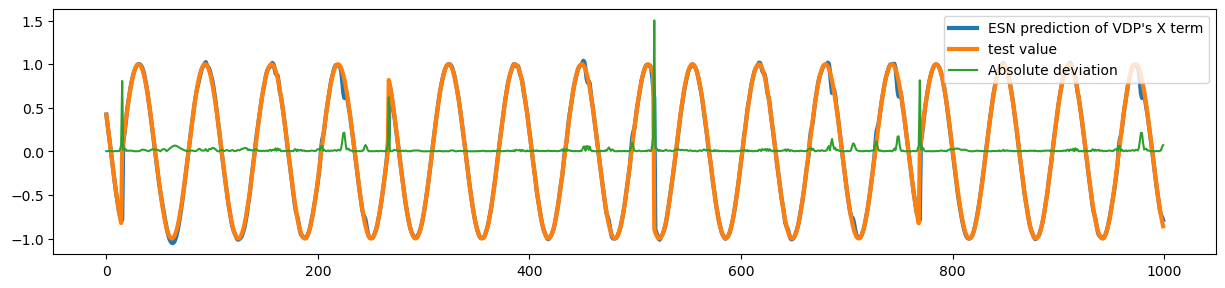

In [16]:
sample = 1000

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, 2:3][:sample], lw=3, label="ESN prediction of VDP's X term")
plt.plot(np.arange(sample), y_test[:, 2:3][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, 2:3][:sample] - predictions[:, 2:3][:sample]), label="Absolute deviation")

plt.legend()
plt.show()

# Generative Model

In [17]:
def multi_generative_model(X, N, iss, lr, ridge, seed, sr, train_len = 2000, forecast=1, seed_timesteps = 100, nb_generations = 400):
    
    n, m = X.shape
    
    from reservoirpy.datasets import to_forecasting

    train_len = train_len

    x, y = to_forecasting(X, forecast=forecast)
    X_train, y_train = x[:train_len], y[:train_len]
    X_test, y_test = x[train_len:], y[train_len:]

    dataset = ((X_train, y_train), (X_test, y_test))
    
    # bestから取得したハイパーパラメータを設定
    N = N
    iss = iss
    lr = lr
    ridge = ridge
    seed = seed
    sr = sr

    # データセットからトレーニングとバリデーションデータを取得
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data

    # モデルの構築
    reservoir = Reservoir(N, 
                        sr=sr, 
                        lr=lr, 
                        input_scaling=iss, 
                        seed=seed)
    readout = Ridge(ridge=ridge)
    model = reservoir >> readout
    
    model = reset_esn()
    
    # モデルの訓練と予測
    predictions = model.fit(X_train, y_train).run(X_val)
    
    seed_timesteps = seed_timesteps

    warming_inputs = X_test[:seed_timesteps]

    warming_out = model.run(warming_inputs, reset=True)  # warmup
    
    nb_generations = nb_generations

    X_gen = np.zeros((nb_generations, m))
    y = warming_out[-1]
    for t in range(nb_generations):  # generation
        y = model(y)
        X_gen[t, :] = y
        
    X_t = X_test[seed_timesteps: nb_generations+seed_timesteps]
    
    return X_gen, X_t, warming_out, warming_inputs

In [18]:
nb_generations = 400
seed_timesteps= 100

In [19]:
# 描画用のplot_generationの定義

def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):

    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations)+seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    if warming_inputs is not None:
        plt.plot(np.arange(seed_timesteps), warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations)+seed_timesteps, np.abs(X_t - X_gen),
             label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup")

    plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_t, X_gen), 4)}$")
    plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_t, X_gen), 4)}$")
    plt.legend(
    )
    plt.show()

In [20]:
X_gen, X_t, warming_out, warming_inputs = multi_generative_model(X, 500, 0.6062643158179813, 0.48657161636196294, 0.00019371347794085468, 1234, 1.3671630828846324, 3000, 1, 100, 400)

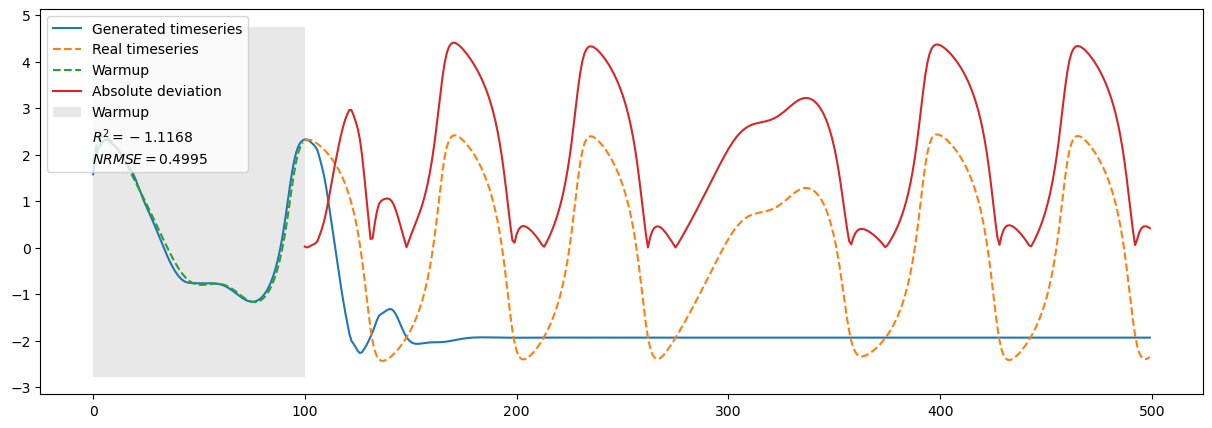

In [21]:
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)

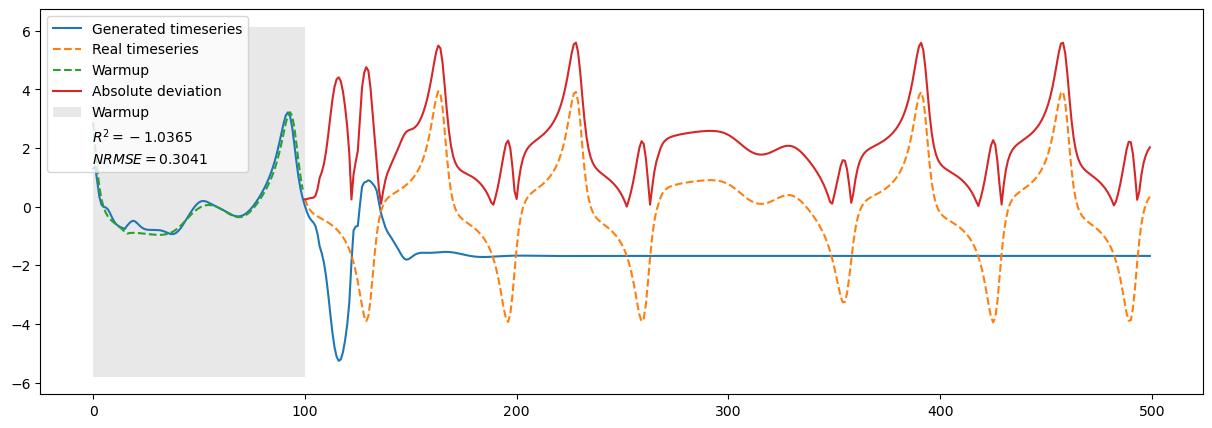

In [22]:
plot_generation(X_gen[:, 1:2], X_t[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)


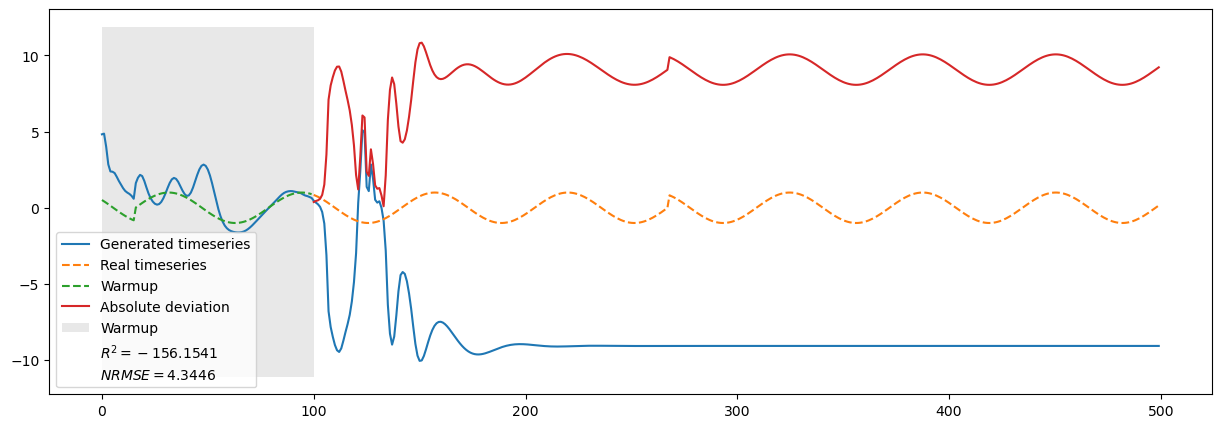

In [23]:
plot_generation(X_gen[:, 2:3], X_t[:, 2:3], nb_generations, warming_out=warming_out[:, 2:3],
                warming_inputs=warming_inputs[:, 2:3], seed_timesteps=seed_timesteps)